<img src='./data/k_t.jpg'>
<center><h1>A framework for deep learning</h1></center>


# Problem Introduction


## The Monte Hall Paradox

In [228]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/9vRUxbzJZ9Y" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')    

<h2>So...</h2>
<p>
Can we train a Neural Network to accurately select the correct door? <br><br>In other words, can a neural network 'learn' conditional probability?
</p>

## Data - Simulation

In [285]:
import numpy as np

doors = [1,2,3]

first_choice = np.ceil(np.random.rand(1000)*3).astype(int)
target = np.ceil(np.random.rand(1000)*3).astype(int)

In [286]:
np.sum(first_choice==target)

343

In [287]:
sim = []

for i in range(len(first_choice)):
    d = doors.copy()

    if first_choice[i] == target[i]:
        d.remove(first_choice[i])
        rand_index = np.random.randint(0,2)
        shown = d[rand_index]
    else:
        d.remove(first_choice[i])
        d.remove(target[i])
        shown = d[0]        
    row = [first_choice[i], shown ,target[i]]
    sim.append(row)           

In [288]:
import pandas as pd
sim = pd.DataFrame(sim, columns=['First Choice', 'Door Shown', 'Target'])

In [289]:
sim.head()

,First Choice,Door Shown,Target
0,3,1,3
1,3,1,2
2,1,2,1
3,2,1,3
4,2,3,1


In [290]:
assert(np.sum(sim['First Choice'] == sim['Target']) != 0) # the first choice is the target some of the time
assert(np.sum(sim['First Choice'] == sim['Door Shown']) == 0) # the door shown is never the first choice
assert(np.sum(sim['Target'] == sim['Door Shown']) == 0) # the door shown is never the target

In [291]:
from keras.utils.np_utils import to_categorical
fc = to_categorical(sim['First Choice']-1)
ds = to_categorical(sim['Door Shown']-1)
t = sim['Target']

In [292]:
data = np.concatenate([fc,ds], axis=1)

In [293]:
data.shape

(1000, 6)

In [294]:
t.shape

(1000,)

In [295]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,t ,test_size=0.20, random_state=42)

In [296]:
y_train = to_categorical(y_train-1)

### Another Classification Model via the Keras Sequential API

In [297]:
from keras.models import Sequential

#get an instance of a Sequential Model
model = Sequential()

from keras.layers import Dense

u_num = X_train.shape[1]

#add some layers to the model
model.add(Dense(units=u_num, activation='relu', input_dim=X_train.shape[1]))#This is the input layer
model.add(Dense(units=u_num, activation='relu', input_dim=u_num))#This is a hidden layer
model.add(Dense(units=u_num, activation='relu', input_dim=u_num))#This is a hidden layer
model.add(Dense(units=u_num, activation='relu', input_dim=u_num))#This is a hidden layer
model.add(Dense(units=y_train.shape[1], activation='softmax', input_dim=u_num))#This is the output layer

model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_133 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_134 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_135 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_136 (Dense)            (None, 3)                 21        
Total params: 189
Trainable params: 189
Non-trainable params: 0
_________________________________________________________________


In [242]:
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, shuffle=True, verbose=0)

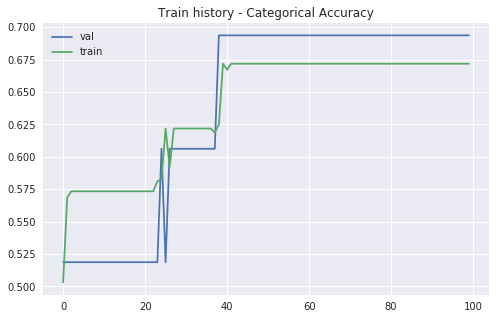

In [243]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(8,5))
ax.set_title('Train history - Categorical Accuracy')
ax.plot(history.history['val_acc'], label='val')
ax.plot(history.history['acc'], label='train')
ax.legend();

<p>Now we will try to predict the holdout set</p>

In [244]:
pred = model.predict(X_test)

<p>pred is an array of arrays of probabilities, so we can use argmax to pull the highest for each instance
    <br><br>
In this case, the Door is 1,2,3 so argmax+1 will produce the actual class label</p>

In [245]:
predictions = [np.argmax(x) + 1 for x in pred]

<p>And compute an accuracy score</p>

In [246]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.67

<p>This result doesn't seem like a great accuracy. It only wins a car 2/3 of the time, but...</p>

<hr><p>Let's unpack this</p>

In [247]:
#first guess is one-hot in the first three columns of the array so we will reverse the encoding
#by selecting the index that has the highest value -- 1
first_guesses = X_test[:,:3]
first_guesses = [np.argmax(x) + 1 for x in first_guesses]
first_guesses[:10]

[3, 3, 2, 3, 3, 3, 1, 1, 2, 1]

In [248]:
#door shown is one-hot in the last three columns of the array so we will reverse the encoding
#by selecting the index that has the highest value -- 1
door_shown = X_test[:,3:]
door_shown = [np.argmax(x) + 1 for x in door_shown]
door_shown[:10]

[2, 1, 3, 1, 2, 1, 2, 3, 3, 3]

In [249]:
#The first few values predicted
predictions[:10]

[1, 2, 1, 2, 1, 2, 3, 2, 1, 2]

<p>So it appears to actually be accurately selecting the higher probability of winning a car in each case -- switch doors</p>

In [250]:
#Does it ever stick with its first guess?
np.sum(first_guesses == predictions)

0

<p>It turns out it switches every time, which means we have accurately modeled the Monty Hall Paradox ... <br>and have '<b>taught conditional probability</b>' to a <b>Neural Network<b></p><hr>

## Teach a Neural Network to play Poker
<p>
Train a Neural network to produce a hold/fold decision based on the quality of their hand. </p>

Data Dictionary:<br>
   1) S1 �Suit of card #1�
      Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

   2) C1 �Rank of card #1�
      Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

   3) S2 �Suit of card #2�
      Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

   4) C2 �Rank of card #2�
      Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

   5) S3 �Suit of card #3�
      Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

   6) C3 �Rank of card #3�
      Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

   7) S4 �Suit of card #4�
      Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

   8) C4 �Rank of card #4�
      Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

   9) S5 �Suit of card #5�
      Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

   10) C5 �Rank of card 5�
      Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

   11) CLASS �Poker Hand�
      Ordinal (0-9)

      0: Nothing in hand; not a recognized poker hand 
      1: One pair; one pair of equal ranks within five cards
      2: Two pairs; two pairs of equal ranks within five cards
      3: Three of a kind; three equal ranks within five cards
      4: Straight; five cards, sequentially ranked with no gaps
      5: Flush; five cards with the same suit
      6: Full house; pair + different rank three of a kind
      7: Four of a kind; four equal ranks within five cards
      8: Straight flush; straight + flush
      9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush


In [251]:
import pandas as pd
df = pd.read_csv(r'./data/poker_train.d',engine='c')
df.columns = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','Class']
print(df.shape)
df.Class.value_counts()

(25009, 11)


0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        4
Name: Class, dtype: int64

## Poker play simulation

<p>We will simulate one hundred thousand deals</p>

In [252]:
import numpy as np

data = []
ten_thousand_hands = []

#simulate 100,000 hands
for _ in range(100000):
    hand = []
    self_cards = []
    first = True
    #deal 4 random hands
    for __ in range(4):
        #we aren't worrying about whether cards have already been dealt... might be a stacked deck
        random_number = np.random.randint(0,df.shape[0])
        hand.append(df.Class.iloc[random_number])
        
        #use the same index to get player cards
        if first == True:
            self_cards.append(df.iloc[random_number])
            first = False
    
    data.append(self_cards)
    ten_thousand_hands.append(hand)

#Turn into dataframes -- self is the nn's hand, p1-p3 are opposing players
ten_thousand_hands=pd.DataFrame(ten_thousand_hands, columns=['self', 'p1', 'p2', 'p3'])

#theses are the corresponding cards in the player's hand for each of the win/loss results
data=pd.DataFrame(np.array(data).reshape(-1,11), columns=['C1', 'S1', 'C2','S2','C3', 'S3', 'C4','S4','C5', 'S5', 'Class'])

In [253]:
print('This is the data that the neural network sees as input\n')
print(data.head())

print('\n\nThis is the simulation of 100,000 hands\n')
print(ten_thousand_hands.head())

This is the data that the neural network sees as input

   C1  S1  C2  S2  C3  S3  C4  S4  C5  S5  Class
0   1   5   2   5   3   6   1   6   3  10      2
1   4   8   3  11   1   8   1   1   1   2      1
2   3   7   1   9   2   2   4   6   4   1      0
3   2   7   4  10   2  12   1   3   1   2      0
4   4  12   1   4   1  11   4   8   4   6      0


This is the simulation of 100,000 hands

   self  p1  p2  p3
0     2   0   0   1
1     1   1   0   0
2     0   0   0   1
3     0   0   1   1
4     0   1   0   0


<p>Now we will produce a training target that is classed as :<br><br>
2 - Player has the best quality hand<br>
1 - Player has a hand that is tied with another player as highest quality hand<br>
0 - Player has a hand of lower quality than at least one other player</p>

In [254]:
target = []
players = {'self':0, 'p1':1,'p2':2,'p3':3}

for row in range(ten_thousand_hands.shape[0]):
    #self has the highest value hand 
    if (np.argmax(ten_thousand_hands.iloc[row]) == 'self') and (ten_thousand_hands.self.iloc[row] > ten_thousand_hands.iloc[row,1:].max()):
        target.append(2)
        
    #self has hand equal to highest value at table
    elif (np.argmax(ten_thousand_hands.iloc[row]) == 'self') and (ten_thousand_hands.self.iloc[row] == ten_thousand_hands.iloc[row,1:].max()):
        target.append(1)
        
    #self does not have highest hand
    else:
        target.append(0)

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [255]:
# How frequently does our player have the best hand?
pd.Series(target).value_counts()

0    53060
1    35115
2    11825
dtype: int64

<p>Sample of target data</p>

In [256]:
target=np.array(target)
target[:10]

array([2, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Categorical input features
<p>Card Suits are categorical, so we will one-hot encode them</p>

In [257]:
S1 = to_categorical(data.S1)
S2 = to_categorical(data.S2)
S3 = to_categorical(data.S3)
S4 = to_categorical(data.S4)
S5 = to_categorical(data.S5)

In [258]:
#we will replace the suit columns with our one-hot arrays, so drop them from the dataset
data.drop(['S1', 'S2','S3','S4','S5'], axis=1, inplace=True)

In [259]:
data.columns

Index(['C1', 'C2', 'C3', 'C4', 'C5', 'Class'], dtype='object')

<p>The card values and class are ordinal, so we will scale them to [0,1] to avoid issues in training<br>
    The easiest way to do that is with sklearn's MaxAbsScaler 

In [260]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
data = scaler.fit_transform(data)

<p>Finally, we will put the one-hot and scaled data back together</p>

In [261]:
data = np.concatenate([np.array(data), S1, S2, S3, S4, S5], axis=1)

### Train Test Split
<p>Once again we will reserve holdout data for model evaluation after training

In [262]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

### One Hot Encoding
<p>The target is, again, a categorical label. As such, we wil lhave to one-hot encode it. <br> 

In [263]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=3)

### Functional API
<p>Keras has 2 apis for building models. The Sequential API will be sufficient for nearly every problem you will be faced wit h(multiple regression, image classification, etc<br><br>
    
BUT...

<p>Sometimes we need a more complex architecture to solve more complex problems<br><br>
We don't really need it, but it helps to see an example     

In [278]:
from keras.models import Model
from keras.layers import Dense, Input
from time import time
from keras.callbacks import TensorBoard


u_num = X_train.shape[1]
n_classes = 3

#add some layers to the model
inpt = Input(shape=(X_train.shape[1],))
l1 = Dense(u_num, activation='relu')(inpt)
l2 = Dense(u_num, activation='relu')(l1)
l3 = Dense(u_num, activation='relu')(l2)
outp = Dense(n_classes, activation='softmax')(l3)

model = Model(inputs=inpt, outputs=outp)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 76)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 76)                5852      
_________________________________________________________________
dense_119 (Dense)            (None, 76)                5852      
_________________________________________________________________
dense_120 (Dense)            (None, 76)                5852      
_________________________________________________________________
dense_121 (Dense)            (None, 3)                 231       
Total params: 17,787
Trainable params: 17,787
Non-trainable params: 0
_________________________________________________________________


In [279]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_split=0.4, verbose = 0,callbacks=[tensorboard])

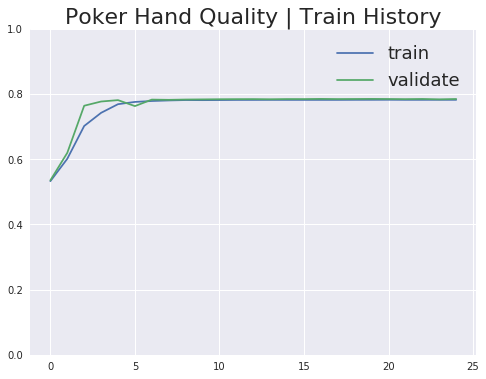

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig,ax = plt.subplots(figsize=(8,6))
ax.set_title('Poker Hand Quality | Train History', fontsize=22)
ax.plot(range(len(history.history['acc'])), history.history['acc'], label='train')
ax.plot(range(len(history.history['acc'])), history.history['val_acc'], label='validate')
ax.legend(fontsize=18)
ax.set_ylim([0,1])
plt.show();

In [267]:
pred = model.predict(X_test)

In [268]:
import numpy as np
predictions = [np.argmax(p) for p in pred]

In [281]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, predictions)
print('{:.2%}'.format(acc))

77.77%


The NN predicts the quality of its hand against that of the other playerrs with a little over 78% accuracy. Let's look at the confusion matrix

In [282]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, predictions), columns=[0,1,2])

,0,1,2
0,10929,2178,105
1,1672,6840,201
2,1,1400,1674


What was the NN holding on 2/0 incorrect predictions?

In [271]:
classes = []
for i in range(len(predictions)):
    if predictions[i] == 2 and y_test[i] == 0:
        classes.append(scaler.inverse_transform(X_test[i][:6].reshape(1,-1))[0,-1].astype(int))

In [272]:
pd.Series(classes).value_counts()

2    94
3     6
1     4
4     1
dtype: int64

It most often incorrectly valued 2 pair as the highest hand at the table

### Can you correctly value the quality of your poker hand greater than 75% of the time?
<hr>

## Challenge 
### Can you modify the training set, model architecture, or model training parameters to improve performance? 
<p><b>Ideas</b></p>
<ul>
    <li>More Intelligent Train Set<ul><li>Deal hands for all players based on standard 52 card deck</li></ul></li>
    <li>Grid Search hyperparameters for model and training</li>
    <li>Try alternate activation functions, layer widths, etc</li>    
</ul>

### Exercise
#### How few lines solve the Conditional Probability example above with the optimal outcome (switch every time)?

<hr>

### Solution 

In [312]:
def switch_doors(c1, c2):
    return [e for e in [1,2,3] if e not in [c1, c2]][0]

In [313]:
print(switch_doors(1,2))
print(switch_doors(3,2))

3
1
